In [274]:
from openseespy.opensees import *
import matplotlib.pyplot as plt
import numpy as np
import opsvis as opsv
%matplotlib widget

In [275]:
wipe() 
model('basic', '-ndm', 2, '-ndf', 3)

In [276]:
# CREATE NODES
B = 8000
H = 3600
node(1, 0, 0)           # Bottom left (fix)
node(2, 0, 500)         # node
node(3, 0, H + 500)     # Top left
node(4, B, 0)           # Bottom right (fix)
node(5, B, 500)         # Node 5
node(6, B, H + 500)     # Top right

node(7, 0, 500)         # left BRB, bottom end
node(8, B/2, 500)       # center steel bracket at bottom
node(9, B, 500)         # right BRB, bottom end

node(10, B/2, H+500)    # BRBs top end
node(11, B/2, H+500)    # Top beam center

node(12, B/2, 0)        # center steel bracket at bottom  (fix)

In [277]:
fix(1, 1, 1, 1)
fix(4, 1, 1, 1)
fix(12, 1, 1, 1)

# Floor diaphragm
equalDOF(11, 3, 1)
equalDOF(11, 6, 1)

#### CREATE MATERIALS AND ELEMENTS

In [278]:
mat_list = {}
def new_mat(matName):
    mat_list[matName] = len(mat_list.keys()) + 1
    return int(mat_list[matName])

def new_ele():
    return getNumElements()[0] + 1

In [279]:
# Beam
# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag)

h_beam = 585.0 # mm
b_beam = 315.0 # mm
A_beam = h_beam * b_beam
Iz_beam = b_beam * (h_beam)**3 / 12
E = 10000.0 # MPa

geomTransf('Linear', 1)
# bottom beam
element('elasticBeamColumn', new_ele(), *[7,8], A_beam, E, Iz_beam, 1)
element('elasticBeamColumn', new_ele(), *[8,9], A_beam, E, Iz_beam, 1)

# top beam
element('elasticBeamColumn', new_ele(), *[3,11], A_beam, E, Iz_beam, 1)
element('elasticBeamColumn', new_ele(), *[11,6], A_beam, E, Iz_beam, 1)

# Add a small rotational spring to mimick pinned joints as they too have some stiffness in reality
# Ensures numerical stability
uniaxialMaterial('Elastic', new_mat("RotSpring"), 1e-12)  # Small stiffness (N-mm/rad)
element('zeroLength', new_ele(), *[3, 3], '-mat', mat_list['RotSpring'], '-dir', 3)
element('zeroLength', new_ele(), *[6, 6], '-mat', mat_list['RotSpring'], '-dir', 3)
element('zeroLength', new_ele(), *[2, 2], '-mat', mat_list['RotSpring'], '-dir', 3)
element('zeroLength', new_ele(), *[5, 5], '-mat', mat_list['RotSpring'], '-dir', 3)

In [280]:
# Column
# element('elasticBeamColumn', eleTag, *eleNodes, Area, E_mod, Iz, transfTag, '-release', 3)

d1_col = 315.0 # mm
d2_col = 315.0 # mm
A_col = d1_col * d2_col
Iz_col = d1_col * (d2_col)**3 / 12
col_nodes = [[1,2], [2,3], [4,5], [5,6]]

geomTransf('Corotational', 2)
# left column
element('elasticBeamColumn', new_ele(), *[1,2], A_col, E, Iz_col, 2)
element('elasticBeamColumn', new_ele(), *[2,3], A_col, E, Iz_col, 2)
# right column
element('elasticBeamColumn', new_ele(), *[4,5], A_col, E, Iz_col, 2)
element('elasticBeamColumn', new_ele(), *[5,6], A_col, E, Iz_col, 2)

In [281]:
## Buckling Restrained Braces (BRBs)
# Steel core
# uniaxialMaterial('Steel4', matTag, Fy, E0, '-kin', b_k, *params, b_kc, R_0c, r_1c, r_2c, '-iso', b_i, rho_i, b_l, R_i, l_yp, b_ic, rho_ic, b_lc, R_ic, '-ult', f_u, R_u, f_uc, R_uc)
# uniaxialMaterial('Steel01', matTag, Fy, E0, b, a1, a2, a3, a4)

uniaxialMaterial('Steel4', new_mat("brbSteelCore"), 
    294.0,                                  # fy
    256200.0,                               # Eeq
    '-kin', 0.004,                          # bk_tension
    25.0, 0.91, 0.15,                       # R0, r1, r2 (tension)
    0.025, 25.0, 0.91, 0.15,                # bk_compression, R0c, r1c, r2c
    '-iso', 0.0008, 1.39, 0.0007, 3.0, 1.0, # bi, rho_it, bl, Ri, lyp
            0.0008, 1.03, 0.0007, 3.0,      # bi_c, rho_ic, bl_c, Ri_c
    '-ult', 485.0, 2.0, 735.0, 2.0          # fu_t, Ru_t, fu_c, Ru_c
)

# For elastoplastic spring to model additional restraints

uniaxialMaterial('Steel01', new_mat("brbSpring"),          
                 27000*4.6,                 # Fy = E0 * yield_displacement
                 27000,                     # E0
                 0.10)                      # post-yield hardening ratio

In [282]:
# BRB
# element('Truss', eleTag, *eleNodes, A, matTag) => represent steel core
# element('twoNodeLink', eleTag, *eleNodes, '-mat', *matTags, '-dir', *dir) => for additional restraint

# left
element('Truss', new_ele(), *[7, 10], 1120, mat_list['brbSteelCore'])
element('twoNodeLink', new_ele(), *[7,10], '-mat', mat_list['brbSpring'], '-dir', 1)
# right
element('Truss', new_ele(), *[9, 10], 1120, mat_list['brbSteelCore'])
element('twoNodeLink', new_ele(), *[9,10], '-mat', mat_list['brbSpring'], '-dir', 1)

<Axes: >

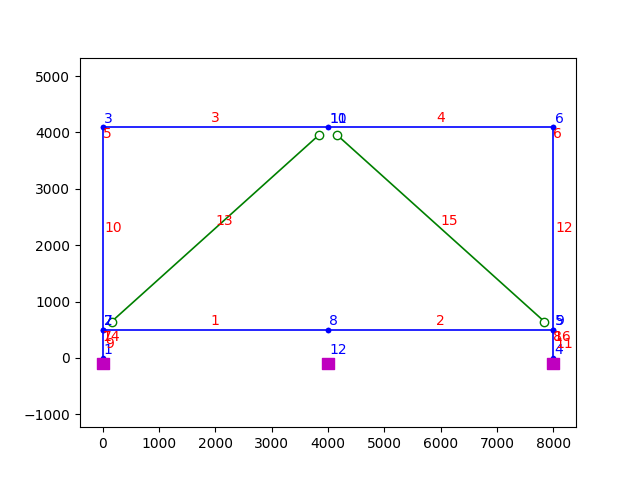

In [283]:
opsv.plot_model()

In [284]:
# Top Dowelled connection - Pinching4 to model cyclic hysteresis for connection

uniaxialMaterial('Pinching4', new_mat("TopDowelPinching4"),
    # Envelope points (positive)
    12028., 0.01,
    421008., 0.7, 
    774948., 2.0, 
    962000., 3.4, 
    # Envelope points (negative)
    -12028., -0.01, 
    -421008., -0.7,
    -774948., -2.0,
    -962000., -3.4,
    # Reloading rules
    0.0, 0.0, -0.05,            # rDispP, rForceP, uForceP
    0.0, 0.0, -0.05,            # rDispN, rForceN, uForceN
    # Degradation (none)
    0., 0., 0., 0., 0.,          # gK1-5
    0., 0., 0., 0., 0.,          # gD1-5
    0., 0., 0., 0., 0.,          # gF1-5
    0.,
   'energy'                   # dmgType
)

# ElasticMultiLinear - simulates initial slip in dowelled connection
uniaxialMaterial("ElasticMultiLinear", new_mat("dowelElasticMultiLinear"),
    "-strain", *[-2.0, -0.5, 0.0, 0.5, 2.0],
    "-stress", *[-2.5e7, -8000, 0.0, 8000, 2.5e7]
)

# Join the materials in series
uniaxialMaterial('Series', new_mat("TopDowelSeriesMat"), mat_list['TopDowelPinching4'], mat_list['dowelElasticMultiLinear'])

uniaxialMaterial('Elastic', new_mat("RotationalPin"), 1.0e-6)  # Very small stiffness

element('zeroLength', new_ele(), *[10, 11], '-mat', mat_list['TopDowelSeriesMat'], mat_list['TopDowelPinching4'], mat_list['RotationalPin'], '-dir', 1, 2, 3)

In [285]:
# Bottom dowelled connection - Pinching4 (half-strength)

uniaxialMaterial('Pinching4', new_mat("bottomDowelPinching4"),
    # Positive envelope
    6014., 0.01,
    210504., 0.7,
    387474., 2.0,
    481000., 3.4,
    # Negative envelope (symmetric)
    -6014., -0.01,
    -210504., -0.7,
    -387474., -2.0,
    -481000., -3.4,
    # Reloading rules
    0.0, 0.0, -0.05,
    0.0, 0.0, -0.05,
    # Degradation
    0., 0., 0., 0., 0.,  # gK1-5
    0., 0., 0., 0., 0.,  # gD1-5
    0., 0., 0., 0., 0.,  # gF1-5
    0.,
    "energy"
)

element('zeroLength', new_ele(), *[2,7], '-mat', mat_list['bottomDowelPinching4'], mat_list['bottomDowelPinching4'], mat_list['RotationalPin'], '-dir', 1, 2, 3)
element('zeroLength', new_ele(), *[5,9], '-mat', mat_list['bottomDowelPinching4'], mat_list['bottomDowelPinching4'], mat_list['RotationalPin'], '-dir', 1, 2, 3)
element('twoNodeLink', new_ele(), *[8,12], '-mat', mat_list['bottomDowelPinching4'], mat_list['bottomDowelPinching4'], mat_list['RotationalPin'], '-dir', 1, 2, 3)

In [286]:
# Add small mass to all nodes
for n in getNodeTags():
    mass(n, 1e-9, 1e-9, 1e-9)  # Minimal translational and rotational masses

In [296]:
circ_freq_sq = eigen(7)
period = [round(2 * np.pi / np.sqrt(each), 6) for each in circ_freq_sq]
print(f"Periods (sec): \n {period}")

Periods (sec): 
 [0.198692, 4e-06, 2e-06, 1e-06, 0.0, 0.0, 0.0]


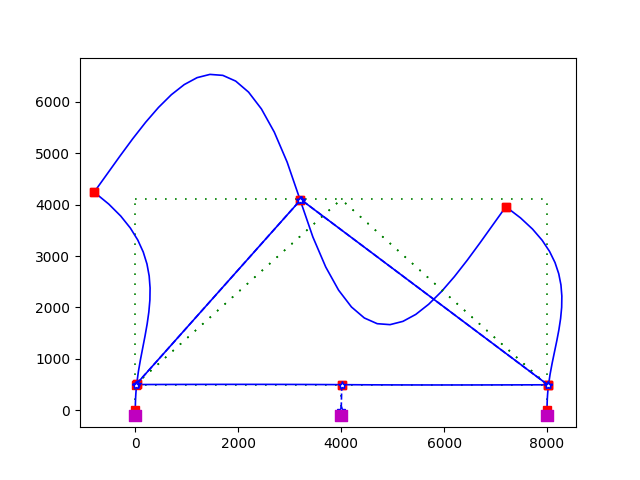

In [301]:
opsv.plot_mode_shape(1, sfac=False)

In [289]:
recorder('Node', '-file', 'node_3_disp.out', '-node', 3, '-dof', 1, 'disp')
recorder('Node', '-file', 'reactions.out', '-node', *[1, 12, 4], '-dof', 1, 'reaction')

21

In [290]:
# APPLY LOADS
timeSeries('Linear', 1)
pattern('Plain', 1, 1)
load(3, *[1.e-3, 0., 0.])

In [291]:
# SETUP ANALYSIS
constraints('Transformation')
numberer('RCM')
system('UmfPack')
test('EnergyIncr', 1e-10, 10000, 0)
algorithm('KrylovNewton')

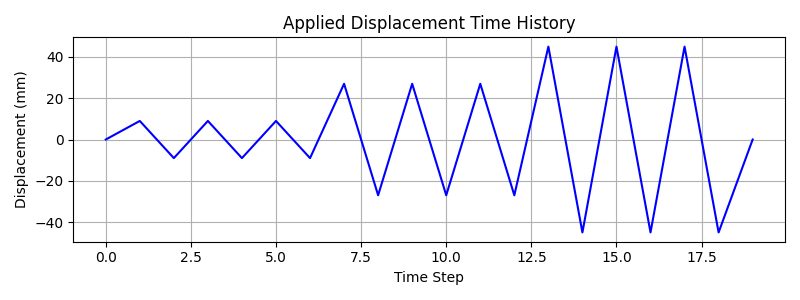

In [292]:
def generate_applied_dips(amplitudes, blocks_per_amplitude=3):
    applied_disp = [0]  # Start at zero
    for amp in amplitudes:
        amp_disp = amp * H / 100 
        for _ in range(blocks_per_amplitude):
            applied_disp.extend([amp_disp, -amp_disp])
    applied_disp.append(0)  # End at zero
    return applied_disp


drift_ratio_amps = [0.25, 0.75, 1.25]
applied_disp = generate_applied_dips(drift_ratio_amps)

# Time axis
time = np.arange(len(applied_disp))

# Plotting
plt.figure(figsize=(8, 3))
plt.plot(time, applied_disp, color='blue', linewidth=1.5)
plt.title("Applied Displacement Time History")
plt.xlabel("Time Step")
plt.ylabel("Displacement (mm)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [293]:
applied_disp

[0,
 9.0,
 -9.0,
 9.0,
 -9.0,
 9.0,
 -9.0,
 27.0,
 -27.0,
 27.0,
 -27.0,
 27.0,
 -27.0,
 45.0,
 -45.0,
 45.0,
 -45.0,
 45.0,
 -45.0,
 0]

In [294]:
# ANALYZE

for step, target_disp in enumerate(applied_disp):
    
    current_disp = nodeDisp(11,1)
    incr = target_disp - current_disp
    integrator('DisplacementControl', 11, 1, incr/1000)  # Larger initial step
    analysis("Static")
    ok = analyze(1000)
    
    if ok != 0:
        print(f"Analysis failed at step {step+1}.")
        break
    else:
        print(f"Step {step+1}: U={current_disp:.4f} mm | Δ={incr:.4f} mm")

Step 1: U=0.0000 mm | Δ=0.0000 mm
Step 2: U=0.0000 mm | Δ=9.0000 mm
Step 3: U=9.0000 mm | Δ=-18.0000 mm
Step 4: U=-9.0000 mm | Δ=18.0000 mm
Step 5: U=9.0000 mm | Δ=-18.0000 mm
Step 6: U=-9.0000 mm | Δ=18.0000 mm
Step 7: U=9.0000 mm | Δ=-18.0000 mm
Step 8: U=-9.0000 mm | Δ=36.0000 mm
Step 9: U=27.0000 mm | Δ=-54.0000 mm
Step 10: U=-27.0000 mm | Δ=54.0000 mm
Step 11: U=27.0000 mm | Δ=-54.0000 mm
Step 12: U=-27.0000 mm | Δ=54.0000 mm
Step 13: U=27.0000 mm | Δ=-54.0000 mm
Step 14: U=-27.0000 mm | Δ=72.0000 mm
Step 15: U=45.0000 mm | Δ=-90.0000 mm
Step 16: U=-45.0000 mm | Δ=90.0000 mm
Step 17: U=45.0000 mm | Δ=-90.0000 mm
Step 18: U=-45.0000 mm | Δ=90.0000 mm
Step 19: U=45.0000 mm | Δ=-90.0000 mm
Step 20: U=-45.0000 mm | Δ=45.0000 mm


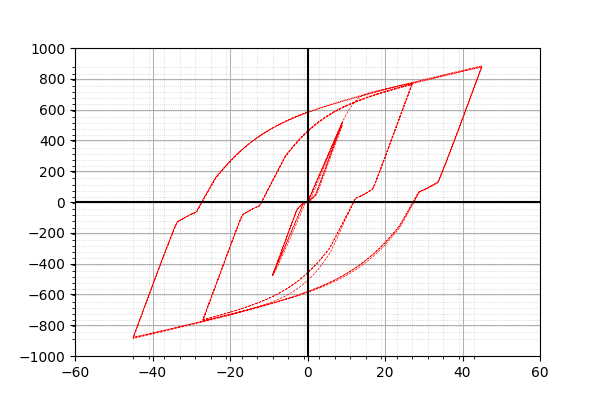

In [295]:
# POST-PROCESSSING ANALYSIS RESULTS

sum_of_rxns = np.sum(np.loadtxt('reactions.out'), axis=1) / -1000  # converting to + and kN
rxn = sum_of_rxns.tolist()
disp = np.loadtxt('node_3_disp.out').tolist()

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(disp, rxn, color='red', linewidth=0.5, linestyle='--')

# Set major ticks
ax.set_xticks([-60, -40, -20, 0, 20, 40, 60])
ax.set_yticks([-1000, -800, -600, -400, -200, 0, 200, 400, 600, 800, 1000])

# Set minor ticks (5 between each major)
ax.set_xticks(np.arange(min(disp), max(disp)+1, 4), minor=True)
ax.set_yticks(np.arange(min(rxn), max(rxn)+1, 40), minor=True)

# Grids
ax.grid(True, which='major', linestyle='-', linewidth=0.75)
ax.grid(True, which='minor', linestyle=':', linewidth=0.5, alpha=0.7)

# Axes lines
ax.axhline(0, color='k')
ax.axvline(0, color='k')

plt.show()